In [1]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *
from utils import *
from scipy.spatial import distance
import seaborn as sns
import umap

In [2]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [3]:
morph_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli')

results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss/morph')

# load all dfs

In [4]:
finetune_pred = pickle.load(open(os.path.join(results_folder, 'norm_robust', 'all_predicted.p'), 'rb'))
pretrain_pred = pickle.load(open(os.path.join(results_folder, 'pretrained', 'pretrained_predicted.p'), 'rb'))
group1_behav = pickle.load(open(os.path.join(results_folder, 'group1_behav_agg.p'), 'rb'))
group2_behav = pickle.load(open(os.path.join(results_folder, 'group2_behav_agg.p'), 'rb'))
group3_behav = pickle.load(open(os.path.join(results_folder, 'group3_behav_agg.p'), 'rb'))

In [5]:
all_groups = pd.concat([finetune_pred, pretrain_pred,
                       group1_behav, group2_behav, group3_behav]).reset_index(drop=True)

In [6]:
all_groups

,index,min_val,max_val,slope,inflection,group,metric
0,ae,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse
1,af,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse
2,ag,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse
3,ah,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse
4,be,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse
...,...,...,...,...,...,...,...
253,eh,2.861325e-02,0.944226,0.179967,78.281169,Group 3,behav
254,cf,4.704466e-02,0.882328,0.261025,51.118444,Group 3,behav
255,df,5.463681e-02,0.939378,0.143298,56.879763,Group 3,behav
256,fg,7.939078e-02,0.928413,0.580742,78.445336,Group 3,behav


In [7]:
all_groups= all_groups.drop(all_groups[all_groups.metric=='frmse'].index).reset_index(drop=True)

In [8]:
all_groups.group.unique()

array(['Group 1', 'Group 2', 'Group 3', nan], dtype=object)

In [9]:
all_groups = all_groups.fillna('Pre-train')

In [10]:
all_groups.metric.unique()

array(['rmse', 'fcosine', 'behav'], dtype=object)

In [11]:
def get_formal_metric(x):
    if x['metric'] == 'rmse':
        return 'MSE'
    elif x['metric'] == 'behav':
        return 'Ground Truth'
    else:
        if x['group'] == 'Pre-train':
            return 'Pre-train'
        else:
            return 'APD'

In [12]:
def get_training_condition(x):
    if x['metric'] == 'rmse':
        return 'MSE'
    elif x['metric'] == 'behav':
        return 'Ground Truth'
    else:
        if x['group'] == 'Pre-train':
            return 'Pre-train'
        else:
            return 'Fine-tune'

In [13]:
all_groups['condition'] = all_groups.apply(get_training_condition, axis=1)

In [14]:
all_groups['metric_formal'] = all_groups.apply(get_formal_metric, axis=1)

In [15]:
all_groups

,index,min_val,max_val,slope,inflection,group,metric,condition,metric_formal
0,ae,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse,MSE,MSE
1,af,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse,MSE,MSE
2,ag,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse,MSE,MSE
3,ah,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse,MSE,MSE
4,be,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse,MSE,MSE
...,...,...,...,...,...,...,...,...,...
183,eh,2.861325e-02,0.944226,0.179967,78.281169,Group 3,behav,Ground Truth,Ground Truth
184,cf,4.704466e-02,0.882328,0.261025,51.118444,Group 3,behav,Ground Truth,Ground Truth
185,df,5.463681e-02,0.939378,0.143298,56.879763,Group 3,behav,Ground Truth,Ground Truth
186,fg,7.939078e-02,0.928413,0.580742,78.445336,Group 3,behav,Ground Truth,Ground Truth


(0.0, 1.0)

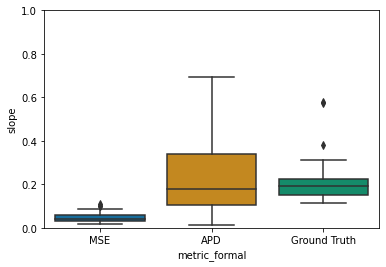

In [16]:
ax = sns.boxplot(y='slope', x='metric_formal',data=all_groups[all_groups.metric_formal.isin(['MSE', 'APD', 'Ground Truth'])],
                order = ['MSE', 'APD', 'Ground Truth'])
ax.set_ylim([0,1])

In [17]:
all_groups['stim'] = all_groups['index']
all_groups = all_groups.drop(columns=['index'])

In [19]:
import statsmodels.formula.api as smf

In [20]:
model = smf.mixedlm("slope ~ C(condition, Treatment('Ground Truth')) ",
                    all_groups[all_groups.metric_formal.isin(['MSE', 'APD', 'Ground Truth'])],
                    groups= "stim").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
===============================================================================================
Model:                          MixedLM               Dependent Variable:               slope  
No. Observations:               165                   Method:                           REML   
No. Groups:                     24                    Scale:                            0.0298 
Min. group size:                5                     Log-Likelihood:                   48.8053
Max. group size:                7                     Converged:                        Yes    
Mean group size:                6.9                                                            
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                             0.209    0.025  8.376 0.000  0.160  0.257
C(condition, Treatment('Ground Truth'))[T.Fine-tune]  0.074    0.035  2.099 0.036  0.005  0.144
C(condition, Treatment('Ground Truth'))[T.MSE]       -0.162    0.032 -5.018 0.000 -0.226 -0.099
stim Var                                              0.000    0.010                           
===============================================================================================

"""

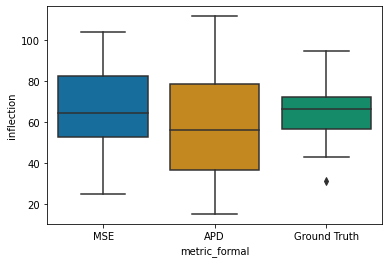

In [99]:
ax = sns.boxplot(y='inflection', x='metric_formal',data=all_groups[all_groups.metric_formal.isin(['MSE', 'APD', 'Ground Truth'])],
                order = ['MSE', 'APD', 'Ground Truth'])

(0.0, 1.0)

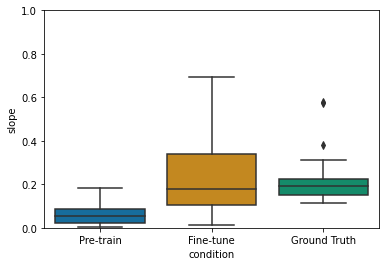

In [100]:
ax = sns.boxplot(y='slope', x='condition',data=all_groups[all_groups.condition.isin(['Pre-train', 'Fine-tune', 'Ground Truth'])],
                order = ['Pre-train', 'Fine-tune', 'Ground Truth'])
ax.set_ylim([0,1])

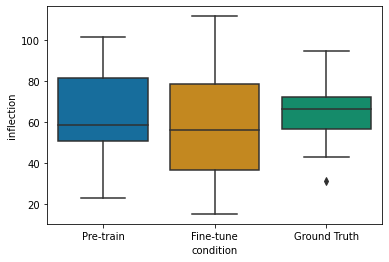

In [101]:
ax = sns.boxplot(y='inflection', x='condition',data=all_groups[all_groups.condition.isin(['Pre-train', 'Fine-tune', 'Ground Truth'])],
                order = ['Pre-train', 'Fine-tune', 'Ground Truth'])

# separate by group

In [102]:
groups = ['Group 1', 'Group 2', 'Group 3']

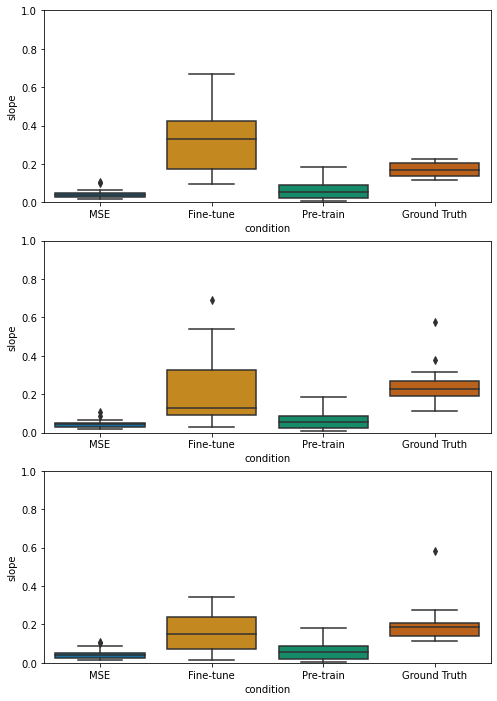

In [103]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
for i, group in enumerate(groups):
    sns.boxplot(y='slope', x='condition',data=all_groups[all_groups.group.isin([group, 'Pre-train'])], ax=ax[i])
    ax[i].set_ylim([0,1])

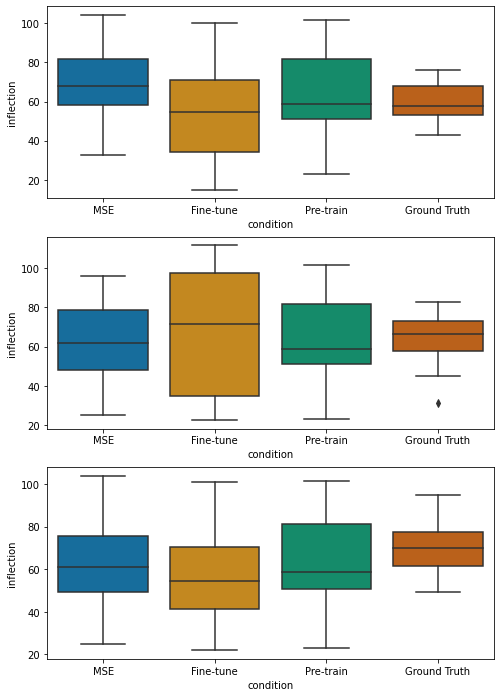

In [104]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
for i, group in enumerate(groups):
    sns.boxplot(y='inflection', x='condition',data=all_groups[all_groups.group.isin([group, 'Pre-train'])], ax=ax[i])

In [105]:
import statsmodels.formula.api as smf

In [106]:
all_groups['stim'] = all_groups['index']

In [107]:
all_groups.head()

,index,min_val,max_val,slope,inflection,group,metric,condition,metric_formal,stim
0,ae,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse,MSE,MSE,ae
1,af,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse,MSE,MSE,af
2,ag,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse,MSE,MSE,ag
3,ah,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse,MSE,MSE,ah
4,be,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse,MSE,MSE,be


In [108]:
all_groups = all_groups.drop(columns=['index'])

In [109]:
model = smf.mixedlm("slope ~ C(condition, Treatment('Ground Truth')) ",
                    all_groups,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
===============================================================================================
Model:                          MixedLM               Dependent Variable:               slope  
No. Observations:               188                   Method:                           REML   
No. Groups:                     4                     Scale:                            0.0263 
Min. group size:                46                    Log-Likelihood:                   65.6418
Max. group size:                48                    Converged:                        Yes    
Mean group size:                47.0                                                           
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                             0.208    0.025  8.231 0.000  0.158  0.257
C(condition, Treatment('Ground Truth'))[T.Fine-tune]  0.074    0.033  2.226 0.026  0.009  0.139
C(condition, Treatment('Ground Truth'))[T.MSE]       -0.162    0.031 -5.225 0.000 -0.222 -0.101
C(condition, Treatment('Ground Truth'))[T.Pre-train] -0.144    0.045 -3.210 0.001 -0.233 -0.056
group Var                                             0.000    0.004                           
===============================================================================================

"""

In [110]:
model = smf.mixedlm("inflection ~  C(condition, Treatment('Ground Truth'))",
                    all_groups,
                    groups= "group").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
================================================================================================
Model:                          MixedLM              Dependent Variable:              inflection
No. Observations:               188                  Method:                          REML      
No. Groups:                     4                    Scale:                           421.6514  
Min. group size:                46                   Log-Likelihood:                  -824.7018 
Max. group size:                48                   Converged:                       No        
Mean group size:                47.0                                                            
------------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                            64.139    2.909 22.051 0.000  58.438 69.840
C(condition, Treatment('Ground Truth'))[T.Fine-tune] -4.673    4.214 -1.109 0.267 -12.932  3.586
C(condition, Treatment('Ground Truth'))[T.MSE]        2.020    3.776  0.535 0.593  -5.380  9.421
C(condition, Treatment('Ground Truth'))[T.Pre-train] -0.838    4.683 -0.179 0.858 -10.016  8.340
group Var                                             0.000                                     
================================================================================================

"""

In [111]:
all_groups

,min_val,max_val,slope,inflection,group,metric,condition,metric_formal,stim
0,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse,MSE,MSE,ae
1,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse,MSE,MSE,af
2,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse,MSE,MSE,ag
3,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse,MSE,MSE,ah
4,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse,MSE,MSE,be
...,...,...,...,...,...,...,...,...,...
183,2.861325e-02,0.944226,0.179967,78.281169,Group 3,behav,Ground Truth,Ground Truth,eh
184,4.704466e-02,0.882328,0.261025,51.118444,Group 3,behav,Ground Truth,Ground Truth,cf
185,5.463681e-02,0.939378,0.143298,56.879763,Group 3,behav,Ground Truth,Ground Truth,df
186,7.939078e-02,0.928413,0.580742,78.445336,Group 3,behav,Ground Truth,Ground Truth,fg


In [112]:
def subtract_behav(group_behav, item):
    def _subtract_behav(x):
        try:
            return x[item]-group_behav[x['stim']][item]
        except:
            return np.NaN
    return _subtract_behav

In [113]:
all_groups.group.unique()

array(['Group 1', 'Group 2', 'Group 3', 'Pre-train'], dtype=object)

In [114]:
pretrain_df = all_groups[(all_groups.condition=='Pre-train')].reset_index(drop=True)
pretrain_df.head()

,min_val,max_val,slope,inflection,group,metric,condition,metric_formal,stim
0,1.000000e-16,0.546898,0.020997,82.679161,Pre-train,fcosine,Pre-train,Pre-train,ae
1,2.792371e-02,1.000000,0.010351,61.352500,Pre-train,fcosine,Pre-train,Pre-train,af
2,6.195373e-02,1.000000,0.027773,49.199347,Pre-train,fcosine,Pre-train,Pre-train,ag
3,3.114233e-01,0.641320,0.074730,72.793759,Pre-train,fcosine,Pre-train,Pre-train,ah
4,2.859399e-01,1.000000,0.088148,95.212692,Pre-train,fcosine,Pre-train,Pre-train,be


In [115]:
import copy
normalized_df = pd.DataFrame()
for group in ['Group 1', 'Group 2', 'Group 3']:
    pretrain_df_group = copy.deepcopy(pretrain_df)
    group_df = all_groups[all_groups.group==group].reset_index(drop=True)
    group_behav = group_df[group_df.condition=='Ground Truth'][['stim', 'slope', 'inflection']].set_index('stim').T.to_dict('stim')
    group_df['d_slope'] = group_df.apply(lambda x: subtract_behav(group_behav, 'slope')(x), axis=1)
    group_df['d_inflection'] = group_df.apply(lambda x: subtract_behav(group_behav, 'inflection')(x), axis=1)
    pretrain_df_group['d_slope'] = pretrain_df_group.apply(lambda x: subtract_behav(group_behav, 'slope')(x), axis=1)
    pretrain_df_group['d_inflection'] = pretrain_df_group.apply(lambda x: subtract_behav(group_behav, 'inflection')(x), axis=1)
    normalized_df = pd.concat([normalized_df, group_df, pretrain_df_group]).reset_index(drop=True)

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/pandas/core/frame.py:1554: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


In [116]:
normalized_df = normalized_df.dropna()

In [117]:
normalized_df

,min_val,max_val,slope,inflection,group,metric,condition,metric_formal,stim,d_slope,d_inflection
0,1.000000e-16,1.000000,0.033214,75.202742,Group 1,rmse,MSE,MSE,ae,-0.088473,23.820172
1,1.000000e-16,0.945304,0.032496,84.500302,Group 1,rmse,MSE,MSE,af,-0.082862,28.164192
2,1.000000e-16,0.860692,0.037051,76.503340,Group 1,rmse,MSE,MSE,ag,-0.081716,28.600583
3,1.000000e-16,0.616709,0.065078,56.980419,Group 1,rmse,MSE,MSE,ah,-0.071602,-11.165764
4,7.801580e-03,0.904488,0.054682,84.002627,Group 1,rmse,MSE,MSE,be,-0.113781,18.117609
...,...,...,...,...,...,...,...,...,...,...,...
206,3.783296e-02,0.859264,0.098685,52.841649,Pre-train,fcosine,Pre-train,Pre-train,bc,-0.090398,-16.651672
207,9.230453e-02,1.000000,0.065240,101.637249,Pre-train,fcosine,Pre-train,Pre-train,bd,-0.053688,20.611946
208,1.000000e-16,0.882292,0.056272,30.104017,Pre-train,fcosine,Pre-train,Pre-train,eh,-0.123695,-48.177152
209,4.780699e-02,1.000000,0.021472,56.000070,Pre-train,fcosine,Pre-train,Pre-train,fg,-0.559270,-22.445266


In [124]:
normalized_df = normalized_df.drop(normalized_df[normalized_df.metric_formal=='Ground Truth'].index).reset_index(drop=True)

In [125]:
normalized_df.groupby('metric_formal')[['d_slope', 'd_inflection']].median()

,d_slope,d_inflection
metric_formal,,
APD,0.010330,-2.792574
MSE,-0.137075,6.699365
Pre-train,-0.121730,0.204055


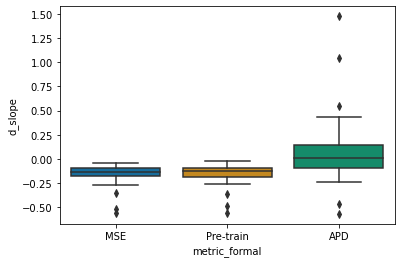

In [127]:
ax = sns.boxplot(x='metric_formal', y='d_slope', data=normalized_df,
                order = ['MSE', 'Pre-train','APD', ])

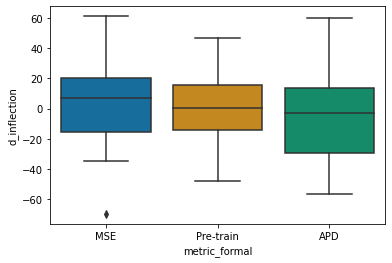

In [128]:
ax = sns.boxplot(x='metric_formal', y='d_inflection', data=normalized_df,
                order = ['MSE', 'Pre-train','APD', ])

In [131]:
model = smf.mixedlm("d_slope ~  C(metric_formal, Treatment('APD'))",
                    normalized_df,
                    groups= "stim").fit()

model.summary()

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                         MixedLM             Dependent Variable:             d_slope
No. Observations:              140                 Method:                         REML   
No. Groups:                    24                  Scale:                          0.0417 
Min. group size:               4                   Log-Likelihood:                 15.0324
Max. group size:               6                   Converged:                      No     
Mean group size:               5.8                                                        
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        0.076    0.031  2.443 0.015  0.015  0.136
C(metric_formal, Treatment('APD'))[T.MSE]       -0.232    0.042 -5.509 0.000 -0.315 -0.150
C(metric_formal, Treatment('APD'))[T.Pre-train] -0.222    0.042 -5.224 0.000 -0.305 -0.139
stim Var                                         0.002    0.013                           
==========================================================================================

"""

In [130]:
model = smf.mixedlm("d_inflection ~  C(metric_formal, Treatment('APD'))",
                    normalized_df,
                    groups= "stim").fit()

model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Mixed Linear Model Regression Results
============================================================================================
Model:                        MixedLM            Dependent Variable:            d_inflection
No. Observations:             140                Method:                        REML        
No. Groups:                   24                 Scale:                         404.1419    
Min. group size:              4                  Log-Likelihood:                -628.8542   
Max. group size:              6                  Converged:                     Yes         
Mean group size:              5.8                                                           
--------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                        -4.527    4.371 -1.036 0.300 -13.094  4.041
C(metric_formal, Treatment('APD'))[T.MSE]         8.199    4.147  1.977 0.048   0.071 16.327
C(metric_formal, Treatment('APD'))[T.Pre-train]   3.465    4.191  0.827 0.408  -4.750 11.679
stim Var                                        251.392    5.189                            
============================================================================================

"""